In [35]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import matplotlib.cm as cm
from datetime import datetime

# setting things up:

In [2]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
output_path = path / "Output"
paths = forcing_path, output_path, observations_path
figure_path = path / "Figures"

In [3]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
names = p_names + S_names
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

var_names =  {x: names[i] for i, x in enumerate(param_names + stor_names)}

In [4]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)
    
def calc_log_NSE(Qo, Qm):
    Qo[Qo == 0] = 1e-6
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((np.log(Qm) - np.log(Qo))**2)
    ErrDo = np.sum((np.log(Qo) - np.log(QoAv))**2)
    return 1 - (ErrUp / ErrDo)

In [5]:
def plot_hydrograph(ds_combined, ax):
    NSE_mean = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    NSE_mean_log = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    
    ds_combined["Q_obs"].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
    
    ds_combined["Q"].sel(summary_stat="mean").plot(ax=ax, color="C1",lw=0.5,label=f"mean NSE: {NSE_mean:.2f}\n   Log NSE: {NSE_mean_log:.2f}",zorder=-1)
    
    ax.fill_between(ds_combined.time, 
                             ds_combined["Q"].sel(summary_stat="min").values,
                             ds_combined["Q"].sel(summary_stat="max").values,color="C0", alpha=0.35,zorder=-10,label="bounds")
    n_particles = ds_combined.attrs['n_particles']
    ax.set_ylabel("Q [mm]")
    ax.set_title(f"Run ensemble of {n_particles} particles");
    return ax

In [6]:
def plot_variable(ds_combined, variable, axs):    
    axs[0] = plot_hydrograph(ds_combined, axs[0])
    n_particles = ds_combined.attrs['n_particles']
    
    for i, var in enumerate(variable):
        for j in range(n_particles):
            axs[i+1].fill_between(ds_combined.time, 
                             ds_combined[var].sel(summary_stat="min").values,
                             ds_combined[var].sel(summary_stat="max").values, color=f"C{i}",alpha=0.5)
            axs[i+1].set_title(var_names[var])
            axs[i+1].set_ylabel(f'{var} [{units[var]}]')
    return axs

# Loading files

In [17]:
files = list((output_path/ "vary around 3.5, 1e-4").glob('*.nc'))

In [18]:
HRU_ids = list(set([file.name.split('_')[0] for file in files]))

In [19]:
dict_files = {}
for file in files:
    sig = file.name.split('_')[1]
    sig = sig[sig.find("-")+1:]
    sig = f"{float(sig):.0e}"
    w = file.name.split('_')[4].split('-')[1]
    dict_files.update(
                       {f"{file.name.split('_')[0]}_{w}_{sig}" : file}
                        )
sorted_iter = sorted(dict_files.keys())[::-1]

In [20]:
len(set([file.name.split("_")[0] for file in files]).intersection(set(HRU_ids)))

1

In [21]:
sorted_iter

['01181000_3.9_5e-04',
 '01181000_3.9_5e-03',
 '01181000_3.9_1e-04',
 '01181000_3.7_5e-04',
 '01181000_3.7_5e-03',
 '01181000_3.7_1e-04',
 '01181000_3.5_5e-04',
 '01181000_3.5_5e-03',
 '01181000_3.5_1e-04',
 '01181000_3.3_5e-04',
 '01181000_3.3_5e-03',
 '01181000_3.3_1e-04',
 '01181000_3.1_5e-04',
 '01181000_3.1_5e-03',
 '01181000_3.1_1e-04']

In [22]:
len(sorted_iter)

15

In [23]:
lst_ds = []
for key in sorted_iter:
    ds = xr.open_dataset(dict_files[key])
    lst_ds.append(ds)

In [24]:
df = pd.DataFrame(columns=["NSE_mean","NSE_mean_log", "sigma_p_Sf","sigma_w"])
for index, ds_combined in enumerate(lst_ds):
    uid = sorted_iter[index]
    df.loc[uid, 'NSE_mean'] = calc_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'NSE_mean_log'] = calc_log_NSE(ds_combined["Q_obs"].values, ds_combined["Q"].sel(summary_stat="mean").values)
    df.loc[uid, 'sigma_p_Sf'] = ds_combined.attrs["sigma_p_Sf"]
    df.loc[uid, 'sigma_w'] = ds_combined.attrs["sigma_w"]

df = df[df['NSE_mean']>0]

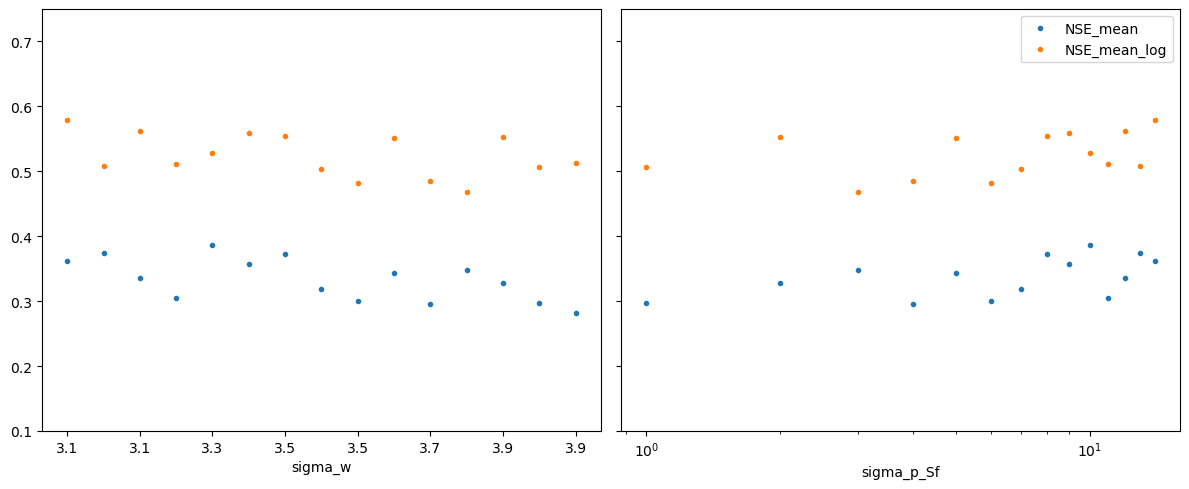

In [36]:
fig, ax = plt.subplots(1,2, sharey=True,figsize=(12,5))
df.plot('sigma_w','NSE_mean',lw=0, marker='.',ax=ax[0],legend=False)
df.plot('sigma_w','NSE_mean_log',lw=0, marker='.',ax=ax[0],legend=False)

df.plot('sigma_p_Sf','NSE_mean',lw=0, marker='.',ax=ax[1])
df.plot('sigma_p_Sf','NSE_mean_log',lw=0, marker='.',ax=ax[1])
ax[0].invert_xaxis()
ax[1].set_ylim(0.1,0.75)
ax[1].set_xscale('log')
fig.tight_layout()
# ax[0].set_xlim((0,5))

current_time = str(datetime.now())[:-10].replace(":","_")
fig.savefig(figure_path / f"{title}_side_{current_time}.png")

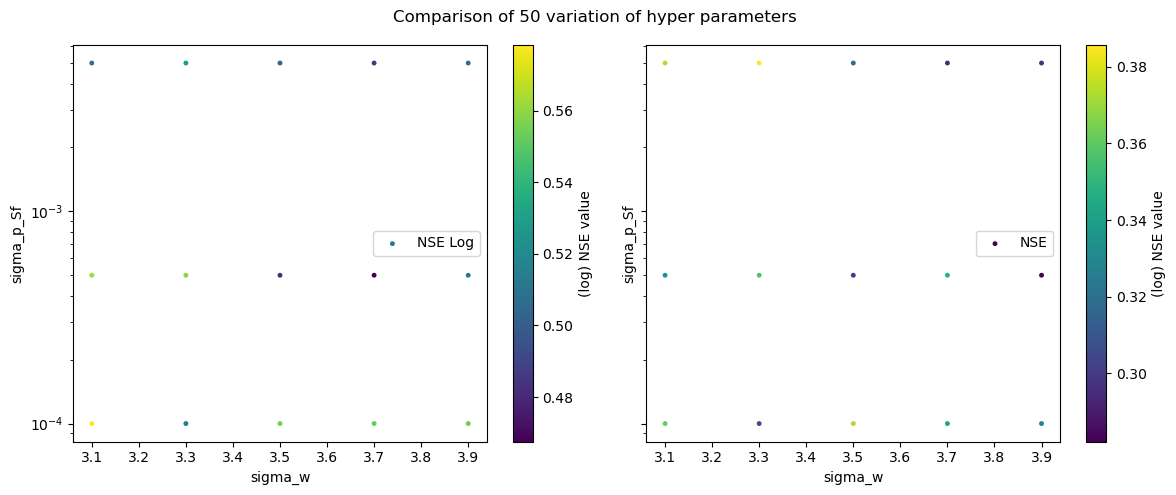

In [27]:
fig, ax = plt.subplots(1,2, sharey=True,figsize=(12,5))
fig.suptitle("Comparison of 50 variation of hyper parameters")
cmap = cm.viridis
cb0 = ax[0].scatter(df['sigma_w'], df['sigma_p_Sf'], c=df['NSE_mean_log'], cmap=cmap, marker='.',s=25,label="NSE Log")
cb1= ax[1].scatter(df['sigma_w'], df['sigma_p_Sf'], c=df['NSE_mean'], cmap=cmap, marker='.',s=25,label="NSE")
for axs in ax:
    axs.set_ylabel('sigma_p_Sf')
    axs.set_xlabel('sigma_w')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].legend()
plt.colorbar(cb0,label="(log) NSE value");
plt.colorbar(cb1,label="(log) NSE value");
fig.tight_layout()



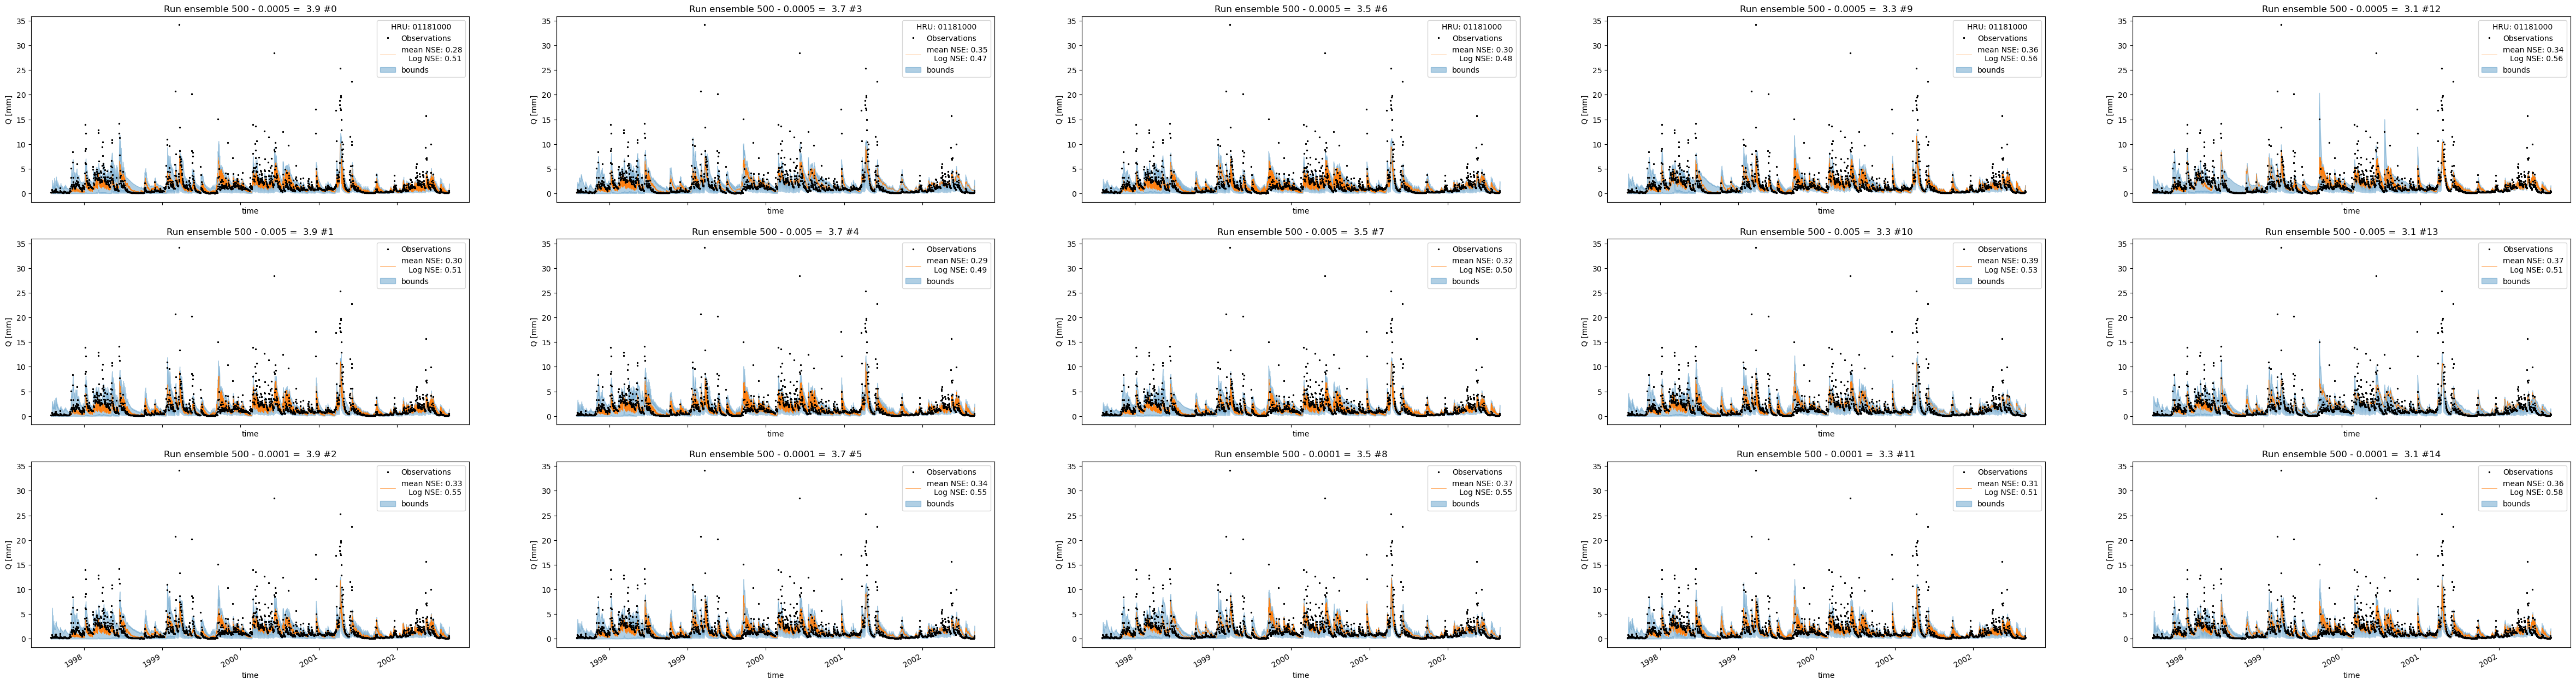

In [28]:
y1, x1   = 3, 5
fig, axs_2d = plt.subplots(y1,x1,figsize=(12*x1,5*y1), sharex=True)
j = 0
k = 0
for i in range(0,x1*y1):
    if k >= y1: 
        j += 1
        k = 0
    ax = axs_2d[k, j]
    k += 1

    if i >= len(lst_ds):
        ax.axis('off')
    else:
        ds_combined = lst_ds[i]
        ax = plot_hydrograph(ds_combined, ax)
        ax.set_title(f'Run ensemble {ds_combined.attrs["n_particles"]} - {ds_combined.attrs["sigma_p_Sf"]} =  {ds_combined.attrs["sigma_w"]} #{i}')
        if k == 1:
            ax.legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
        else:
            ax.legend()

# fig.savefig(figure_path / f'itterate_sigma_p_sf_first-{x1}_catchments.png', bbox_inches="tight",dpi=400)

In [29]:
i = 3
ds_combined = lst_ds[i]
ds_combined

<xarray.Dataset>
Dimensions:       (summary_stat: 3, time: 1857)
Coordinates:
  * summary_stat  (summary_stat) object 'min' 'max' 'mean'
  * time          (time) datetime64[ns] 1997-08-01 1997-08-02 ... 2002-08-31
Data variables: (12/18)
    Imax          (summary_stat, time) float64 ...
    Ce            (summary_stat, time) float64 ...
    Sumax         (summary_stat, time) float64 ...
    Beta          (summary_stat, time) float64 ...
    Pmax          (summary_stat, time) float64 ...
    Tlag          (summary_stat, time) float64 ...
    ...            ...
    Ss            (summary_stat, time) float64 ...
    Sp            (summary_stat, time) float64 ...
    Q             (summary_stat, time) float64 ...
    Q_obs         (time) float64 0.2111 0.2011 0.191 ... 0.2011 0.5529 0.2916
    Neff          (time) float64 ...
    n_resample    (time) float64 ...
Attributes:
    title:              HBV storage & parameter terms data over time for 500 ...
    history:            Storage term results from ewatercycle_HBV.model
    sigma_pp:           0.005
    sigma_ps:           0.005
    sigma_w:            3.7
    sigma_p_Sf:         0.0005
    assimilate_window:  3
    n_particles:        500
    HRU_id:             01181000

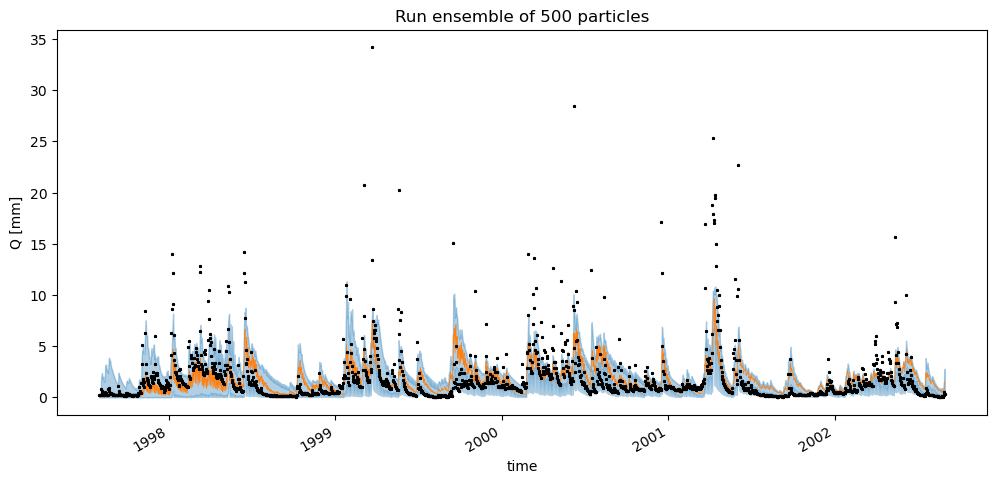

In [30]:
fig, ax = plt.subplots(1,1, figsize=(12,5),sharex=True)
ax = plot_hydrograph(ds_combined, ax)
# ax.set_xlim((pd.Timestamp("1997-08-01"),pd.Timestamp("1999-06-06")))

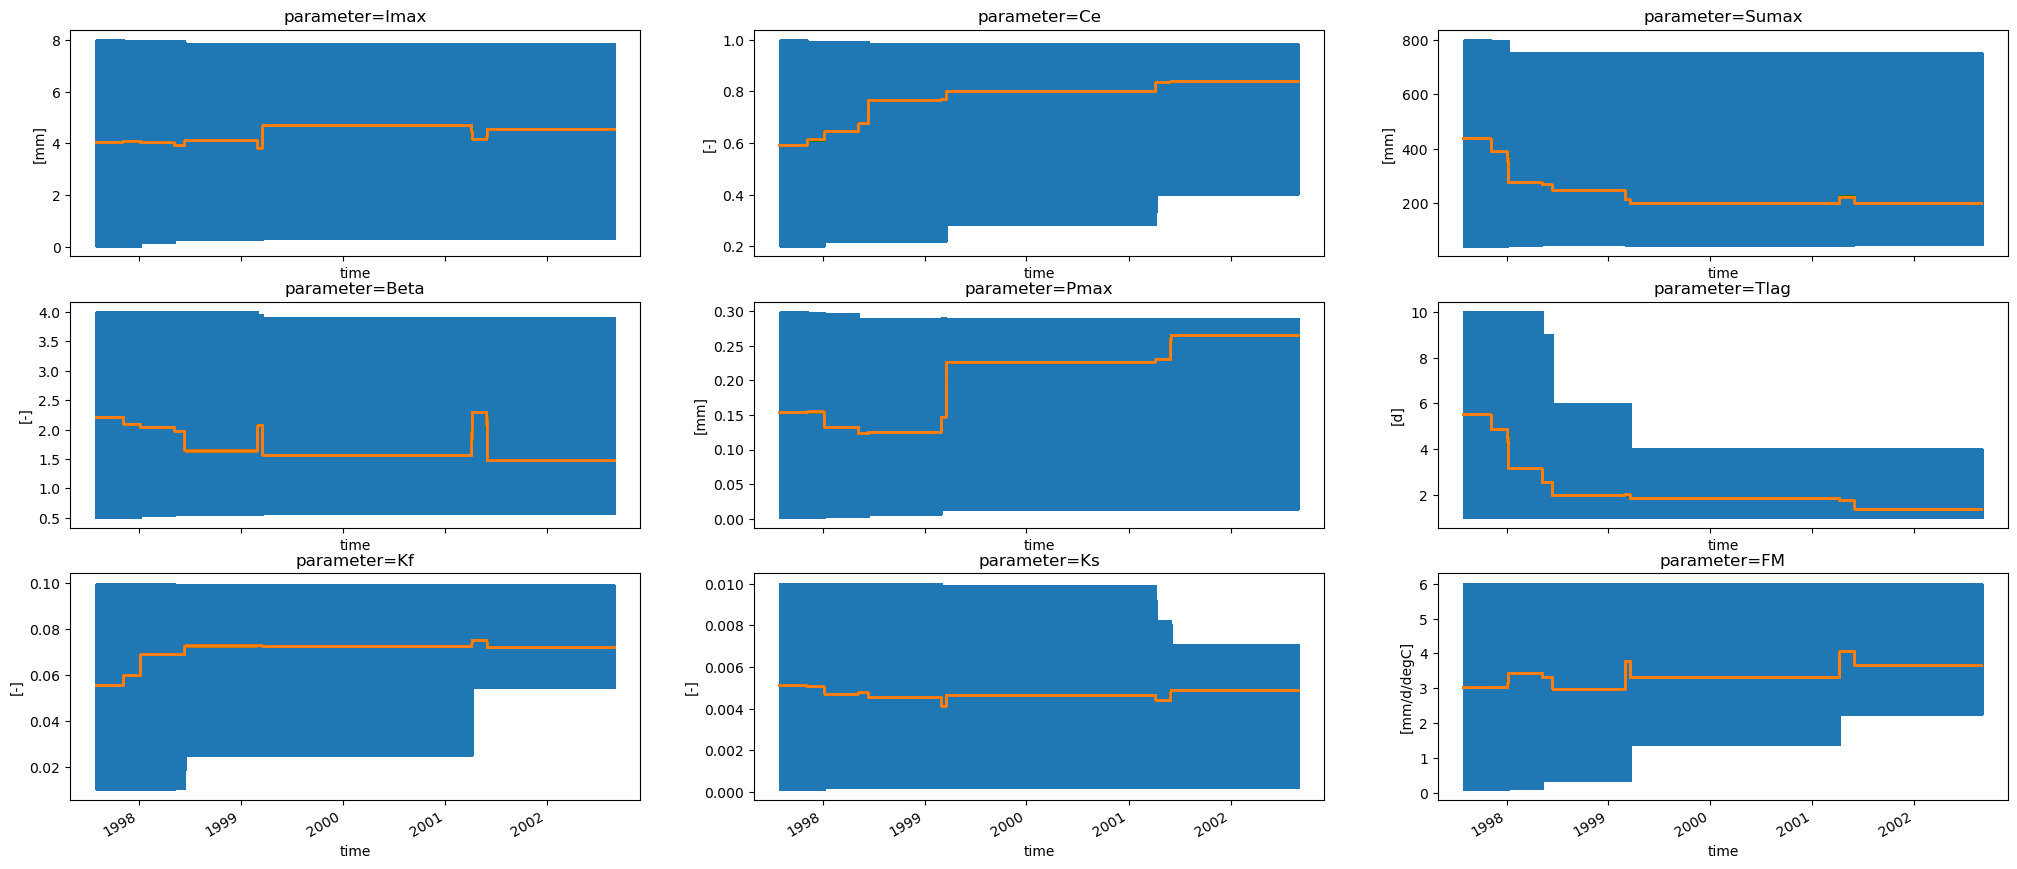

In [31]:
fig, axs = plt.subplots(3,3,figsize=(25,10),sharex=True)
axs = axs.flatten()
for j, parameter in enumerate(param_names):
    ax = axs[j]
    n_particles = ds_combined.attrs['n_particles']
    for i in range(n_particles):
        ds_combined[parameter].sel(summary_stat="mean").plot(ax=ax,alpha=0.5,color="C1")
        ax.fill_between(ds_combined.time, 
                         ds_combined[parameter].sel(summary_stat="min").values,
                         ds_combined[parameter].sel(summary_stat="max").values,alpha=0.3, color="C0")
    ax.set_title(f'parameter={parameter}')# for {n_particles} Ensemble Members')
    ax.set_ylabel(f'[{units[param_names[j]]}]')

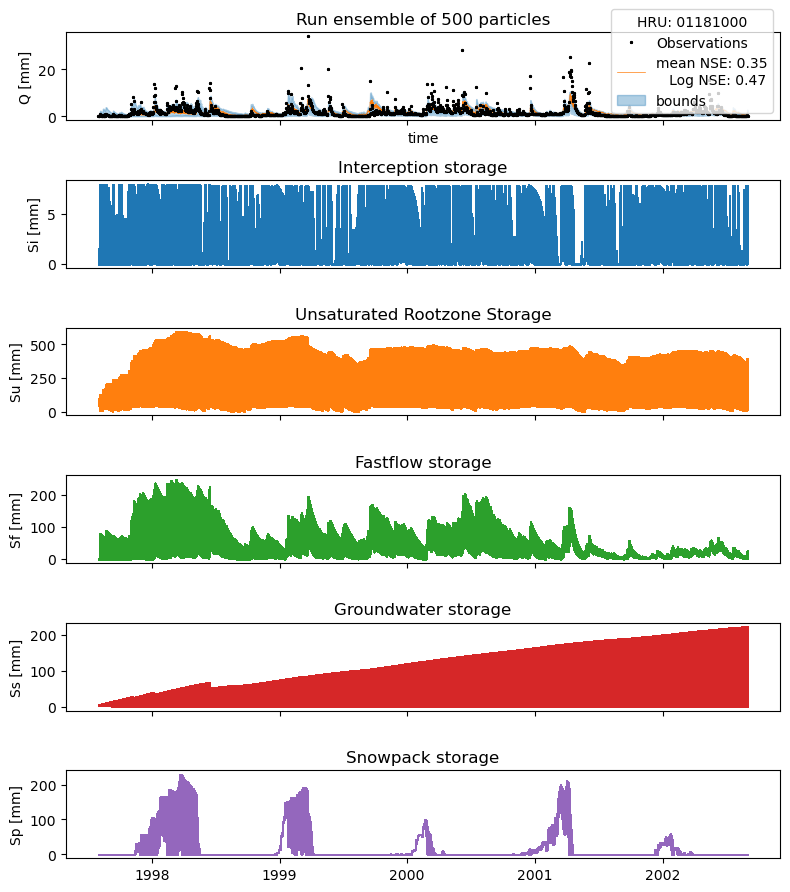

In [32]:
n=6
fig, axs = plt.subplots(n,1,figsize=(8,n*1.5),sharex=True)
plot_variable(ds_combined, stor_names, axs)
fig.tight_layout()
axs[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}")
# fig.savefig(figure_path / (str(files[i].name[:-3]) + '_storages.png'), bbox_inches="tight",dpi=400)

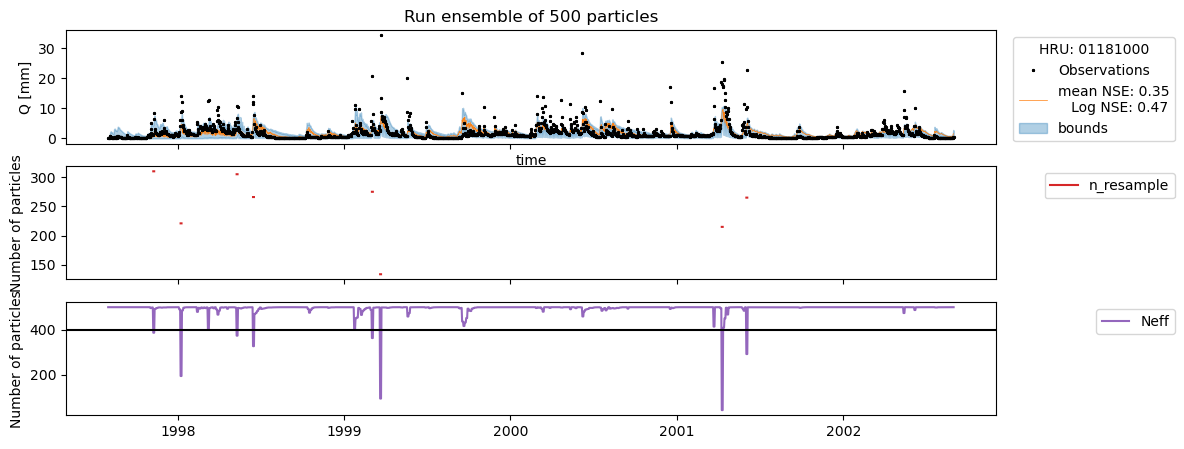

In [33]:
fig, ax = plt.subplots(3,1, figsize=(12,5),sharex=True)
ax[0] = plot_hydrograph(ds_combined, ax[0])
ax[0].legend(title=f"HRU: {ds_combined.attrs['HRU_id']}",bbox_to_anchor=(1.2,1))
for j, val in enumerate(['n_resample','Neff']):
    ax[j+1].plot(ds_combined['time'].values, ds_combined[val].values,color=f"C{j+3}",label=val)
    ax[j+1].legend(bbox_to_anchor=(1.2,1))
    ax[j+1].set_ylabel('Number of particles')
ax[2].axhline(ds_combined.attrs['n_particles']*0.8, color='k');